# HCI Week 3 - Coronagraphs Part I
*Matthew Kenworthy // Leiden Observatory*

Today we cover encircled energy plots and simulate a simple Lyot coronagraph. Read through the functions defined in the block below, as they may help with the exercises.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams['figure.figsize'] = [10, 5]

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')


def displC(c,trim=0):
    # displC - display a Complex number c as four plots
    #          as a (Real, Imaginary) pair and as
    #          an Amplitude, Phase plot
    #          optionally cut out the central square with size trim by trim pixels   
    c2 = np.copy(c)
    if (trim>0): # if the user specifies a trim value, cut out the centre of the image
        (nx,ny) = c.shape
        dx = np.array((nx-trim) / 2).astype(int)
        dy = np.array((nx-trim) / 2).astype(int)
        c2 = c[dx:dx+trim,dy:dy+trim]
        
    # set up the plot panels
    fig=plt.figure(figsize=(10,8))
    axre = fig.add_subplot(221)
    axim = fig.add_subplot(222)
    axamp = fig.add_subplot(223)
    axpha = fig.add_subplot(224)
    # plot out the panels
    im = axre.imshow(c2.real)
    im = axim.imshow(c2.imag)
    im = axamp.imshow(np.abs(c2))
    im = axpha.imshow(np.angle(c2))
    
    axre.set_title('Real')
    axim.set_title('Imag')
    axamp.set_title('Amplitude')
    axpha.set_title('Phase')
    plt.show()

def padcplx(c,pad=5):
    # padcplx - puts a Complex array in the centre of a zero-filled Complex array
    #           pad defines the padding multiplier for the output array
    (nx, ny) = c.shape
    bignx = nx*pad
    bigny = ny*pad
    big_c = np.zeros((bignx,bigny),dtype=complex)

    dx = np.array((nx * (pad-1)) / 2).astype(int)
    dy = np.array((ny * (pad-1)) / 2).astype(int)

    big_c[dx:dx+nx,dy:dy+ny] = c
    return(big_c)

def FFT(c,pad=5):
    """FFT - carry out the complex Fourier transform (with optional padding)
    and return the FFT padded array"""
    from numpy.fft import fft2,fftshift,ifft2,ifftshift
    psfA = fftshift(fft2(ifftshift(padcplx(c,pad))))
    return psfA

def IFFT(c,pad=5):
    """FFT - carry out the complex Fourier transform (with optional padding)
    and return the FFT padded array"""
    from numpy.fft import fft2,fftshift,ifft2,ifftshift
    psfA = fftshift(ifft2(ifftshift(padcplx(c,pad))))
    return psfA

def circle_mask(im, xc, yc, rcirc):
        ny, nx = im.shape
        y,x = np.mgrid[0:nx,0:ny]
        r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
        return ( (r < rcirc))
    

def r_theta(im, xc, yc):
    # returns the radius rr and the angle phi for point (xc,yc)
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

def phi_ramp(im, npx, npy):
    ny, nx = im.shape
    ly = np.linspace(-0.5, 0.5, ny) * np.pi * npy * 2
    lx = np.linspace(-0.5, 0.5, nx) * np.pi * npx * 2
    
    x, y = np.meshgrid(lx, ly) 
    return(x+y)

def logit(im, minlog=-6):
    # logit - takes the log10 of an image and rounds up tiny logs to minlog so that displC()
    #         works better
    imout = np.copy(im)
    logimout = np.log10(imout)
    logimout[(logimout<minlog)] = minlog
    return(logimout)

**Q1 (2 points):** The first stage is to make a telescope pupil with a diameter of 101 pixels. The pupil is circular with no central obscuration, and the circle must touch all 4 sides of the square. Make this a complex amplitude pupil with an amplitude per pixel of 1 and zero phase, and call this telescope pupil `A`.

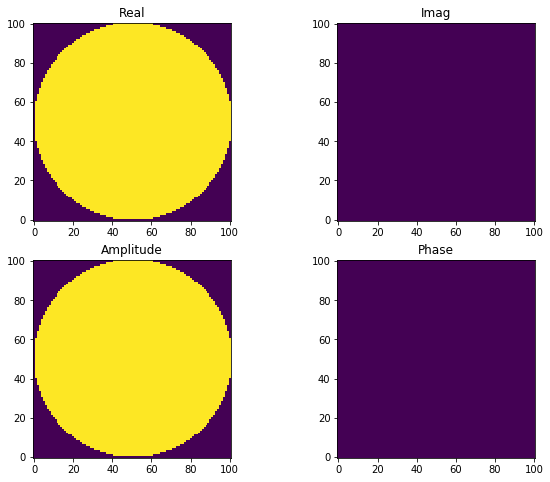

In [2]:
dtel = 101 # pixels

# Q1 answer start
y,x = np.mgrid[:dtel,:dtel]

xcen, ycen, r = 50.5, 50.5, 50.5
circle = (x-xcen)**2 + (y-ycen)**2 < r**2

phase = np.zeros_like(circle)

A = circle * np.exp(1j * phase)

# Q1 stop

displC(A)
# print(A.min())

## Conserving flux from Pupil to Focal Planes
We should normalise the **intensity** of the telescope pupil to a value of 100.0 intensity units. 

**Q2 (2 points):** Write a subroutine to calculate the summed intensity of a complex amplitude input image and have it return a real number. Call this routine `Isum()` and use it to normalise the telescope pupil amplitude `A`. Show that you have done the normalisation correctly by showing that `Isum(A) = 100.0` 

In [3]:
# Q2 answer here
# from astropy import convolution

def Isum(a):
    pupil = np.abs(a)
    conj = np.conj(pupil)
    norm = pupil * conj
    return norm.sum()
nA = (A / np.sqrt(Isum(A)))*10

# Q2 end of answer

print(Isum(nA))

100.0


**Q3 (2 points):** Calculate the Amplitude Spread Function (ASF) for this telescope pupil with a sampling of 7 (use a variable `nsamp` to hold this, as you may want to easily change this value later on), and call this new complex amplitude `B`. Print out the `Isum` of `B`. Since energy is conserved, you should get `Isum(B) = 100.0` - but you don't. Instead it's a much higher number. There is a normalisation factor that will get you back to `100.0`, and you can calculate it from your input `A`. 

**HINT:** it's related to how the FFT routine works, and involves a very simple quantity associated with all `numpy` arrays. Look at the `numpy` documentation for all properties associated with a defined numpy variable, and also look at what the scaling factor appears to be.

Show that you have normalised B correctly by making `Bn` be the correctly normalised version of `B` and show `Isum(Bn) = 100.0` 


In [4]:
nsamp = 7

# Q3 answer here
B = FFT(nA,nsamp)
print('Isum(B) =',Isum(B))
Bn = B / (A.shape[0]*nsamp)

# Q3 answer end

print(Isum(Bn))

Isum(B) = 49984899.99999999
99.99999999999999


## Calculating encircled energy as a function of radius
The energy of the star (or planet) is spread out over the focal plane in an Airy disk of radius $1.22 \lambda / D$, where our sampling `nsampl` is equal to $\lambda / D$.

**Q4 (4 points):** Write a routine  `ee(im, xap, yap, r_ap)` to calculate the fraction of encircled energy within a circular aperture of radius `r_ap` centered at `(xap, yap)` in a complex image `im`.

To improve efficiency, make it so that `r_ap` can be a numpy array of radii, and use a `for` loop with `enumerate()` to return a numpy array of encircled energy values. 

**HINT** Look at the routine `r_theta()` at the start of the Practicum

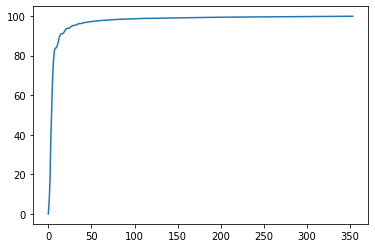

In [5]:
# Q4 answer here
def ee(im, xap, yap, r_ap):
    energy = np.zeros((r_ap.shape[0]))
    r,t = r_theta(im,xap,yap) 
    for i, r_ap in enumerate(r_ap):
        energy[i] = Isum(im[r<r_ap])
    return energy

tel_samp= dtel*nsamp
    
radii = np.arange(0,tel_samp/2)

en_energy = ee(Bn,tel_samp/2,tel_samp/2,radii)
# print(en_energy.max())
plt.plot(radii,en_energy)

# Q4 end

**Q5 (6 points):** Plot out the encircled energy versus increasing aperture radii for the PSF in `B`.

Starting with a radius of 1 pixel, go in steps of 1 pixel out to $10 \lambda/D$. Label the x-axis of the plot in unit of $\lambda/D$. (Yes, I know I'm changing units on you!)

Plot a vertical line at a radius of $1.22 \lambda/D$.

What is the *fraction* of the total energy enclosed within a radius of $1.22 \lambda/D$? 

**Sanity check** what should the EE be for very large radii?

Enclosed Energy at diffraction limit =  [0.83781435]


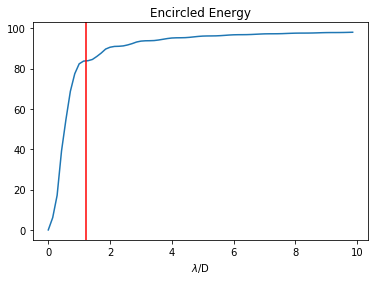

In [6]:
# Q5 answer here

radii_samp = radii / nsamp
max_radii = 10.

plt.title('Encircled Energy')
plt.xlabel('$\lambda$/D')
plt.plot(radii_samp[(radii_samp<max_radii)],en_energy[(radii_samp<max_radii)])
plt.axvline(1.22,color='r')

radii_diff = np.array([1.22*nsamp])
enc_diff = ee(Bn,tel_samp/2,tel_samp/2,radii_diff)
print('Enclosed Energy at diffraction limit = ',enc_diff/100)

## Coronagraph Simulator

Here is a simple optical layout of a telescope, coronagraph, and science imaging camera. The figure is taken from [Sivaramakrishnan and Oppenheimer (2006)](http://adsabs.harvard.edu/abs/2006ApJ...647..620S).

<img src="coronagraph.png">


  * A is the telescope entrance pupil
  * B is the first focal plane
  * $m(k)$ is the focal plane coronagraphic mask
  * C is the masked first focal plane
  * D is the Lyot pupil plane
  * $N(x)$ is the Lyot pupil plane coronagraphic mask
  * E is the masked Lyot plane
  * F is the final focal plane
  
Many types of coronagraph can be specified with $m(k)$ and $N(x)$, resulting in attenuation for on-axis sources whilst letting as much light from a nearby companion through.

The axis of the coronagraph is at  the central pixel `xcen,ycen` of `B`, `C` and `F`, and we will refer to this pixel as being at the origin, i.e. $(x,y)=(0,0)$ for the central pixel.

This week we will make a Lyot coronagraph and compare its efficiency at transmitting and rejecting light compared to direct imaging. We define the function `coro()` which produces the final science camera focal plane image `F` and all the intermediate planes. 

In [7]:
def coro(A, m, N, nsamp):
    B = FFT(A,nsamp)
#     B /= np.sqrt(B.size)
    C = m * B
#     C /= np.sqrt(C.size)
    D = IFFT(C,1)
#     D /= np.sqrt(D.size)
    E = N * D
#     E /= np.sqrt(E.size)
    F = FFT(E,1)
#     F /= np.sqrt(F.size)

    return(B/np.sqrt(B.size),C/np.sqrt(C.size),D,E,F/np.sqrt(F.size))

First things first - let's see that `coro()` works by putting in two transmissive masks for `m` and `N`. Remember that both masks will have to be padded to the same size as `B` in order for `coro()` to work. 

**Q6 (6 points):** Use the telescope pupil `A` with `Isum = 100.0` and `nsamp=7`, and show that the `Isum` of `B`,`C`,`D`,`E` and `F` are all `100.0` (or very close to this, depending on numerical precision). Remember that you will have to correct the intensities according to the relation you found out earlier in the notebook.

In [8]:
# Q6 answer here
focal_mask = padcplx(np.ones(nA.shape),pad=nsamp)
pupil_mask = padcplx(np.ones(nA.shape),pad=nsamp)

B,C,D,E,F = coro(nA,focal_mask,pupil_mask,nsamp)

print('Isum(nA): = ', Isum(nA))
print('Isum(B): = ', Isum(B))
print('Isum(C): = ', Isum(C))
print('Isum(D): = ', Isum(D))
print('Isum(E): = ', Isum(E))
print('Isum(F): = ', Isum(F))

Isum(nA): =  100.0
Isum(B): =  99.99999999999999
Isum(C): =  97.47126093490989
Isum(D): =  97.47126093490992
Isum(E): =  97.09160758157003
Isum(F): =  97.09160758156997


We put the star we wish to block on the central axis of the coronagraph - this is done already with telescope pupil `A`, normalised to `Isum(A) = 100.0`.

**Q7 (2 points):** Make a copy of `A` using `np.copy()` and call it `A_star`, and use `coro()` to generate the PSF at the first focal plane and call it `B_star`. 

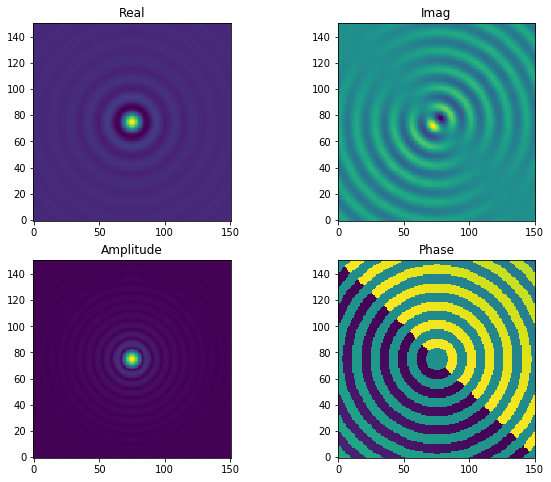

In [9]:
# Q7 answer here
A_star = np.copy(nA)
B_star,C,D,E,F = coro(A_star,focal_mask,pupil_mask,nsamp)
displC((B_star),151)

We can now make a planet that is 10000 times fainter **in energy** than the star, and move it off the axis of the coronagraph by adding a tilt in phase across the telescope pupil.

**Q8 (6 points):** Make a planet image that is $5 \lambda / D$ along the +ve x-axis by making a copy of the star's telescope pupil, and adding a suitable ramp of phase to the telescope pupil - call this `A_planet` and using `coro()` and `displC(B_planet, 151)` show that the resultant PSF of the planet in the first focal plane `B` is moved off of the central axis of the coronagraph.

**HINT** Go look at `phi_ramp()` and see what it's doing.

Isum(B_planet) =  0.01
Isum(B_star) =  99.99999999999999


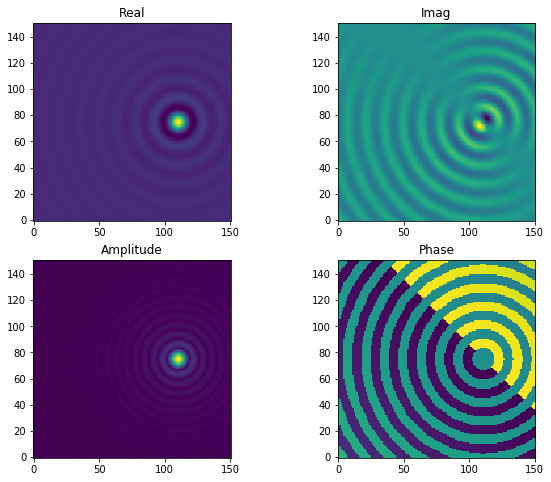

In [10]:
# Q8 answer here
planet_phase = phi_ramp(A_star,5.0,0.0)

A_planet = np.copy(A_star)
A_planet *= np.sqrt(1e-4) * np.exp(1j*planet_phase)

B_planet = coro(A_planet,focal_mask,pupil_mask,nsamp)[0]
print('Isum(B_planet) = ', Isum(B_planet))
print('Isum(B_star) = ', Isum(B_star))

displC(B_planet,151)



The diffracted light from the star forms a **halo** of light in the science camera focal plane `F`. We can compare the halo of light from the star with the flux from the planet at the $5 \lambda / D$ location. We will do this by plotting the star's PSF and planet PSF and comparing relative fluxes.

**Q9 (4 points):** Write a routine `xaxis_energy(im,xr)` that takes a complex image `im`, cuts out the line of pixels from -xr to +xr across the middle of the image (equivalent to $y=0$) and returns the *energy per pixel* along that line.

In [11]:
# print(len(A[1]))
def xaxis_energy(im, xr):
    xcen = int(im.shape[1]/2)
    xvals = np.arange(xcen-xr,xcen+xr)
    clip_vals = im[xcen,xcen-xr:xcen+xr]
    clip_energy = np.abs(clip_vals)
    im_return = clip_energy*clip_energy
    return im_return,xvals

    
# Q9 answer here

We compare the **direct imaging** case first by looking at the PSFs of the star and the planet in the `B` values.

The peak of the PSF of the star is in the middle of the array `B_star`. 

**Q10 (6 points):** Plot out the `log10` energy of the PSF centered on the axis of the coronagraph along the x axis from -10 to + 10 $\lambda/D$ . The x-axis should be labelled in units of $\lambda/D$.

You should see that the planet's peak flux is slightly below the stellar halo at $5 \lambda/D$.

Overplot the planet's PSF on the same graph. the Python notebook automatically does this if you run two or more `plt.plot()` commands within the same code cell.

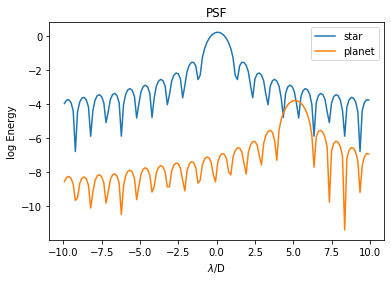

In [12]:
# Q10 answer here
Bstar_en, Bstar_vals = xaxis_energy(B_star,nsamp*10)
Bplanet_en, Bplanet_vals = xaxis_energy(B_planet,nsamp*10)
#Centering
Bplanet_vals = (Bplanet_vals  - np.median(Bstar_vals)) / nsamp
Bstar_vals = (Bstar_vals  - np.median(Bstar_vals)) / nsamp

plt.plot(Bstar_vals,np.log10(Bstar_en),label = 'star')
plt.plot(Bplanet_vals,np.log10(Bplanet_en),label = 'planet')
plt.ylabel('log Energy')
plt.xlabel('$\lambda$/D')
plt.title('PSF')
plt.legend()
plt.show()

Finally, let's put in a classical Lyot coronagraph!

A classical Lyot coronagraph consists of a hard-edged occulter in the first focal plane, followed by a Lyot stop in the second pupil (the Lyot) plane.

**Q11 (4 points):** Make a hard edged mask `m_lyot` that has a radius of $3 \lambda/D$. It should have a transmission of 0 within this radius, and a transmission of 1 outside this radius. Assume there is no phase change with light passing through the mask.

Display the effect of the mask `m_lyot` on the planet's PSF `B_planet` by calculating `C_planet` and then use `displC(x, 151)`


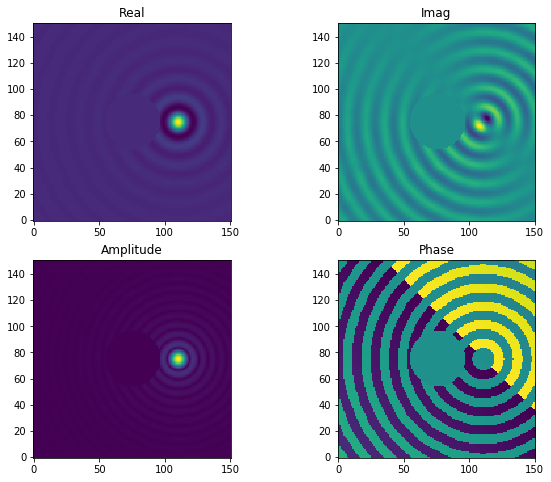

In [13]:
# Q11 answers here
m_lyot = 1. - circle_mask(B_planet, tel_samp / 2, tel_samp / 2, 3.*nsamp)
C_planet = coro(A_planet,m_lyot,pupil_mask,nsamp)[1]
displC(C_planet,151)

Make the Lyot stop `N_lyot` so that it blocks all light outside 0.8 times the diameter of the pupil at location `D` in the coronagraph, and run the coronagraph simulator for both the star and the planet.

**Q12 (4 points):** Make the same logarithmic energy plots with the same x-axis range for the final science camera plane `F_star` and `F_planet`. Which object is brighter at $5 \lambda/ D$ now?

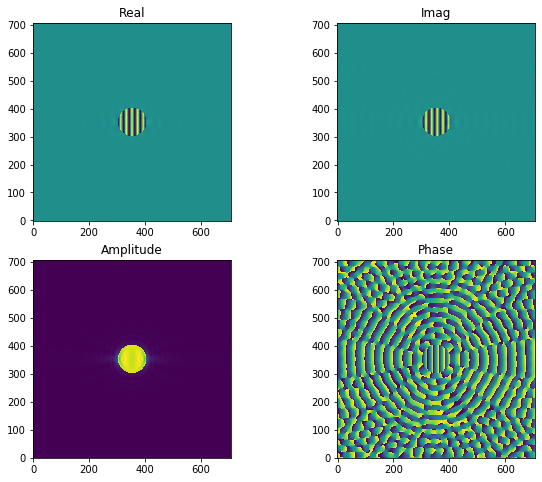

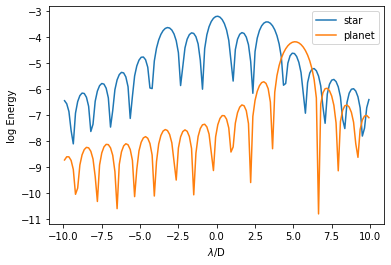

In [15]:
# Q12 answer here
D_planet = coro(A_planet,m_lyot,pupil_mask,nsamp)[2]
displC(D_planet)


N_lyot = circle_mask(D_planet, tel_samp / 2, tel_samp / 2,0.8*dtel/2)
F_star = coro(A_star,m_lyot,N_lyot,nsamp)[4]
F_planet = coro(A_planet,m_lyot,N_lyot,nsamp)[4]

#Clipping
Fstar_en, Fstar_vals = xaxis_energy(F_star,nsamp*10)
Fplanet_en, Fplanet_vals = xaxis_energy(F_planet,nsamp*10)
#Centering
Fplanet_vals = (Fplanet_vals  - np.median(Fstar_vals)) / nsamp
Fstar_vals = (Fstar_vals  - np.median(Fstar_vals)) / nsamp

#Plotting
plt.plot(Fstar_vals,np.log10(Fstar_en),label='star')
plt.plot(Fplanet_vals,np.log10(Fplanet_en), label = 'planet')
plt.xlabel('$\lambda$/D')
plt.ylabel('log Energy')
plt.legend()

**Q13 (2 points):** Overplot `B_star` and `F_star` on the same plot. Estimate by eye the suppression factor of the coronagraph by looking at the peak of the PSFs.

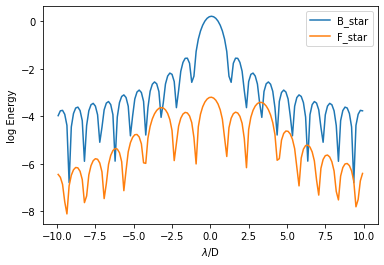

In [16]:
# Q13 answer here

plt.plot(Bstar_vals,np.log10(Bstar_en),label = 'B_star')
plt.plot(Fstar_vals,np.log10(Fstar_en),label = 'F_star')
plt.ylabel('log Energy')
plt.xlabel('$\lambda$/D')
plt.legend()

## Best guess by eye, it looks like there is a supression of $10^4$ 

**Q14 (2 points):** Overplot `B_planet` and `F_planet`. What has happened to the Airy rings? Why?


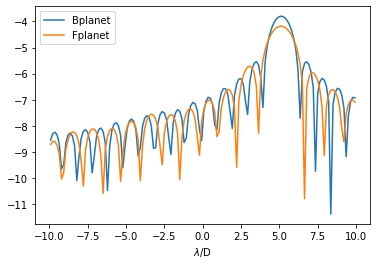

In [17]:
# Q14 answer here

plt.plot(Bplanet_vals,np.log10(Bplanet_en),label = 'Bplanet')
plt.plot(Fplanet_vals,np.log10(Fplanet_en), label = 'Fplanet')
plt.xlabel('$\lambda$/D')
plt.legend()

## Not sure if I did something wrong but the Airy rings seem to match exactly except for where the lyot stop is present

The star and the planet are incoherent sources with respect to each other, and so the image on the sky is the sum of their separate intensities.

**Q15 (2 points):** Make an intensity image of the star and planet before the coronagraph, and display it with `displC(logit(x),151)`.

Make an image after the coronagraph as well. You should be able to see the planet.

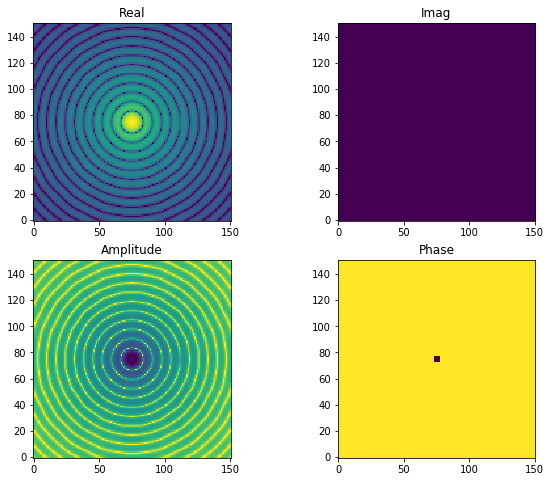

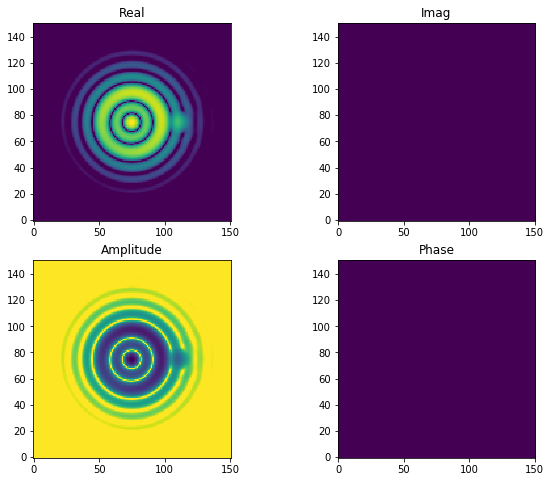

In [18]:
# Q15 answer here
# incoherent_sum = coro(A_star+A_planet,m_lyot,N_lyot,nsamp)

# list = [0,-1]
# list[1]

# for i in range(len(list)):
#     displC(logit(incoherent_sum[i]),151)

def E_to_I(im):
    I_star = np.abs(im)
    I_star = I_star * I_star
    return I_star

intensity = []
img_list = [B_star,B_planet,F_star,F_planet]

for i in range(len(img_list)):
    intensity.append(E_to_I(img_list[i]))

BIntensity = intensity[0]+intensity[1]
FIntensity = intensity[2]+intensity[3]

displC(logit(BIntensity),151)
displC(logit(FIntensity),151)

# I_Bstar = np.abs(B_star)
# I_Bstar = I_Bstar*I_Bstar
# I_Bplanet = np.abs(B_planet)
# I_Bplanet = I_Bplanet * I_Bplanet
# x = (I_Bstar + I_Bplanet)
# displC(logit(x),151)
# I_Fstar = np.abs(F_star)
# I

**Q16 (8 points):** Adjust the Lyot stop size from 0.5 to 1.0 times the diameter of the pupil, and adjust the diameter of the hard-edged stop so that you optimise the brightness of the planet compared to the stellar halo. What are the problems that you find with small Lyot stops?

# Q16 answer here
# I found that the default values gave the clearest picture of the exoplanet
# I found that a small lyot stop gives lower resolution to the planets Airy Core
